# Milestone 2: EDA
## Module E: Predicting COVID-19 Cases
- Austin Rochon
- Emily Xie
- Mark Lock

<hr style="height:2pt">

## Table of Contents

0. [Introduction](#introduction)
1. [Global COVID-19 Data](#global)
2. [U.S. COVID-19 Data](#us)
3. [Analyzing Predictors](#predictors)  
    a. [Google Community Mobility Reports](#google_community_reports)  
    b. [Google Search Data](#google_search_data)  
4. [Takeaways and Future Ideas](#future_ideas)

<a id='introduction'></a>
## Introduction
For our project (Module E), we are focusing on the COVID-19 pandemic. In particular, we will eventually want to predict future COVID-19 cases, given current predictor data. Thus, we are seeking to answer the question: **can we accurately project future COVID-19 cases, given predictor data?** In this milestone, will will be focusing on the EDA of both our predictor and response data. Our reponse data here will be the count of confirmed cases, and our potential predictors will be defined in the sections below. Therefore, much of the scope of the work in our EDA will be to answer the question: **which data points are predictive of future COVID-19 cases?**.  Now that we have outlined the scope of our EDA work, we can immediately answer the first question in the milestone assignment:


**Given everything you have learned, if you faced this data set in the wild, how would you proceed?** 
    
Because we are examining COVID-19 data, which is being reported in real time, we don't have to answer this question hypothetically. We are facing this data set "in the wild". We've approached the COVID-19 data by 1) exploring and summarizing the response data (cases) by examining it by several different groupings (country, state, etc). Next, we examined a few potential predictors to see which had the most power in projecting future cases. 

<a id='global'></a>
## Global COVID-19 Data
We'll start by examining the global COVID-19 data provided by [Johns Hopkins University](https://github.com/CSSEGISandData).

In [13]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime

import folium
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# fetch global data from the Johns Hopkins github
covid_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [15]:
# clean global data. first, transpose all date columns such that we have a single date column
# with each date entry as a row
dates = []
non_dates = ["Province/State", "Country/Region", "Lat", "Long"]
for col in covid_global.columns:
    if col not in non_dates:
        dates.append(col)
        
    
covid_global = pd.melt(covid_global, id_vars=non_dates, value_vars=dates,
                var_name="date", value_name="confirmed")

# next, simplify the column names to make analysis later easier
covid_global.rename(columns={"Province/State": "province", 
                             "Country/Region": "country",
                             "Lat": "lat",
                             "Long": "long"}, inplace=True)
covid_global.head()

,province,country,lat,long,date,confirmed
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0


In [16]:
# store most recent figures to a dataframe
max_date = covid_global["date"].max()
covid_global_mostrecent = covid_global.loc[covid_global["date"] == max_date]

In [17]:
covid_global_mostrecent

,province,country,lat,long,date,confirmed
28462,NaN,Afghanistan,33.000000,65.000000,5/8/20,3778
28463,NaN,Albania,41.153300,20.168300,5/8/20,850
28464,NaN,Algeria,28.033900,1.659600,5/8/20,5369
28465,NaN,Andorra,42.506300,1.521800,5/8/20,752
28466,NaN,Angola,-11.202700,17.873900,5/8/20,43
...,...,...,...,...,...,...
28723,NaN,Western Sahara,24.215500,-12.885800,5/8/20,6
28724,NaN,Sao Tome and Principe,0.186360,6.613081,5/8/20,208
28725,NaN,Yemen,15.552727,48.516388,5/8/20,34
28726,NaN,Comoros,-11.645500,43.333300,5/8/20,8


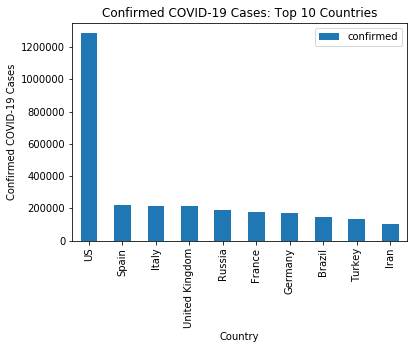

In [18]:
covid_global_mostrecent.sort_values("confirmed", ascending=False).iloc[:10].plot.bar(x="country", y="confirmed")
plt.ylabel("Confirmed COVID-19 Cases")
plt.xlabel("Country")
plt.title("Confirmed COVID-19 Cases: Top 10 Countries");

<a id='us'></a>
## U.S. COVID-19 Data
For the remainder of our EDA, we will focus on U.S. COVID-19 data. We made this decision so that we could go deeper in the analysis 

For the U.S. data, we will use the [CovidTracking Project's](https://covidtracking.com/api) dataset instead of the Johns Hopkins data set. The CovidTracking project has better access to test data. We'll start by loading and cleaning that data.

# NOTE: The analysis below is best viewed in the Jupyter NB viewer. Just click this link for best rendering: 
https://nbviewer.jupyter.org/github/spottedd-spotify/disease_project/blob/master/milestone2_eda/milestone2_eda.ipynb#us

In [19]:
# load daily covid data, per state
covid_us_states = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")

In [20]:
covid_us_states.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200509,AK,378.0,26071.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,26449,26449,26449,2,0.0,0.0,975.0,1.0,976.0
1,20200509,AL,9567.0,115927.0,NaN,NaN,1228.0,NaN,459.0,NaN,...,1228.0,125494,125494,125494,1,13.0,21.0,5034.0,346.0,5380.0
2,20200509,AR,3747.0,61781.0,NaN,64.0,471.0,NaN,NaN,14.0,...,471.0,65528,65528,65528,5,0.0,5.0,1481.0,53.0,1534.0
3,20200509,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83,83,83,60,0.0,0.0,0.0,0.0,0.0
4,20200509,AZ,10960.0,117980.0,NaN,739.0,1514.0,296.0,NaN,186.0,...,1514.0,128940,128940,128940,4,15.0,32.0,8599.0,434.0,9033.0


In [21]:
# add full state name as a column
states_dict = states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

covid_us_states["name"] = covid_us_states["state"].map(states_dict)
covid_us_states.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,name
0,20200509,AK,378.0,26071.0,NaN,8.0,NaN,NaN,NaN,NaN,...,26449,26449,26449,2,0.0,0.0,975.0,1.0,976.0,Alaska
1,20200509,AL,9567.0,115927.0,NaN,NaN,1228.0,NaN,459.0,NaN,...,125494,125494,125494,1,13.0,21.0,5034.0,346.0,5380.0,Alabama
2,20200509,AR,3747.0,61781.0,NaN,64.0,471.0,NaN,NaN,14.0,...,65528,65528,65528,5,0.0,5.0,1481.0,53.0,1534.0,Arkansas
3,20200509,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,...,83,83,83,60,0.0,0.0,0.0,0.0,0.0,American Samoa
4,20200509,AZ,10960.0,117980.0,NaN,739.0,1514.0,296.0,NaN,186.0,...,128940,128940,128940,4,15.0,32.0,8599.0,434.0,9033.0,Arizona


In [22]:
# next, load population data
us_states_population = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv")
us_states_population = us_states_population[["NAME", "POPESTIMATE2019"]]
us_states_population.rename(columns={"NAME":"name", "POPESTIMATE2019": "population"}, inplace=True)

In [23]:
# join to cases
covid_us_states = covid_us_states.merge(us_states_population, on="name", how="inner")

# create cases/per capita and test/per capita columns
covid_us_states["positive_percap"] = covid_us_states["positive"] / covid_us_states["population"]
covid_us_states["tests_percap"] = covid_us_states["totalTestResults"] / covid_us_states["population"]
covid_us_states.head()

# join to lat/long
state_latlong = pd.read_csv("./data/statelatlong.csv")[["State", "Latitude", "Longitude"]]
state_latlong.rename(columns={"State": "state", 
                              "Latitude": "lat",
                              "Longitude": "long"}, inplace=True)
covid_us_states = covid_us_states.merge(state_latlong, on="state", how="inner")

How about a bubble plot. 
NOTE: To see the bubble plot below, please view it here:

https://nbviewer.jupyter.org/github/spottedd-spotify/disease_project/blob/master/milestone2_eda/milestone2_eda.ipynb#us

In [24]:
us_states_geo = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
date = covid_us_states["date"].max()
covid_us_states_mostrecent = covid_us_states.loc[covid_us_states["date"] == date]

In [28]:
# https://python-graph-gallery.com/313-bubble-map-with-folium/

# make an empty map of the US
m = folium.Map(location=[30, -90], zoom_start=4)
 
# add bubbles according to the relative cases
for i in range(0,len(covid_us_states_mostrecent)):
    coords = [covid_us_states_mostrecent.iloc[i]['lat'], covid_us_states_mostrecent.iloc[i]['long']]
    state = covid_us_states_mostrecent.iloc[i]['state']
    cases = int(covid_us_states_mostrecent.iloc[i]['positive'])
    cases_per_cap = covid_us_states_mostrecent.iloc[i]['positive_percap']
    
    folium.Circle(
      location=coords,
      popup=f"{state}\n{cases}",
      radius=cases_per_cap*30000000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

# plot
m.save('../images/US_covid_map.html')
m


<a id='predictors'></a>
## Analyzing Predictors
As we've done with our initial EDA above, we'll only examine US COVID-19 data here. We may expand to all countries in the future. 

In the sections that follow our initial EDA, we answer the final two questions:    
* **What are the important measures?**
* **What are the right questions to ask, and how can the data answer them?**



<a id='google_community_reports'></a>
### Google COVID-19 Community Mobility Reports
One important measure that could be predictive of covid cases is community mobility. Intuitively, if members of a community are moving around a lot, you might expect to see more covid cases, as there are more transmission vectors when people are freely moving. 

In March of 2020, Google began publishing [Community Mobility Reports](https://www.google.com/covid19/mobility/), which tracked changes in activity from pre-coronavirus norms to now for countries agross the world. In particular, it tracked changes in mobility for the following six categories: 
- Retail & recreation
- Grocery & pharmacy
- Parks
- Transit stations
- Workplaces
- Residential

We'll start by loading the data. Note: Google publishes their data in pdf format. The following csv was generated by a github user's pdf scraper, and is current as of 4/5/2020. We'll need to run the script to update the data for later iterations of this project. For time purposes, we're sticking to the 4/5/2020 data here. 

In [12]:
# mobility_us_states = pd.read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/google_reports/mobility_report_US.csv")


hi = mobility_us_states.loc[(mobility_us_states["state"] == "Hawaii") & (mobility_us_states["county"] == "Total")]

hi

,state,county,date,retail,grocery and pharmacy,parks,transit stations,workplaces,residential
38099,Hawaii,Total,2020-02-15,2.0,2.0,19.0,4.0,-1.0,0.0
38100,Hawaii,Total,2020-02-16,4.0,3.0,15.0,4.0,-1.0,-1.0
38101,Hawaii,Total,2020-02-17,5.0,-4.0,14.0,-2.0,-47.0,11.0
38102,Hawaii,Total,2020-02-18,0.0,-2.0,1.0,6.0,-1.0,1.0
38103,Hawaii,Total,2020-02-19,-1.0,-2.0,1.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
38172,Hawaii,Total,2020-04-28,-48.0,-28.0,-59.0,-67.0,-48.0,13.0
38173,Hawaii,Total,2020-04-29,-49.0,-29.0,-58.0,-67.0,-47.0,22.0
38174,Hawaii,Total,2020-04-30,-48.0,-25.0,-57.0,-65.0,-46.0,21.0
38175,Hawaii,Total,2020-05-01,-47.0,-24.0,-58.0,-65.0,-44.0,22.0


In [8]:
# retrieve county-level mobility reports for each US state
mobility_us_states = pd.read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/google_reports/mobility_report_US.csv")
max_date = mobility_us_states["date"].max()

# condense to state-level
mobility_us_states = mobility_us_states.loc[(mobility_us_states["county"] == "total") &
                                            (mobility_us_states["date"] == max_date)]

mobility_us_states.head()

,state,county,date,retail,grocery and pharmacy,parks,transit stations,workplaces,residential


In [55]:
mobility_merged = mobility_us_states[["State", "Retail & recreation", "Grocery & pharmacy",
                                      "Parks", "Transit stations", "Workplaces", "Residential"]]
mobility_merged = mobility_merged.merge(
    covid_us_states.loc[covid_us_states["date"] == int(max_date.replace("-", ""))],
    how="inner", left_on="State", right_on="name")[
    ["state", "name", "Retail & recreation", "Grocery & pharmacy", "Parks", "Transit stations",
     "Workplaces", "Residential", "positive_percap"]]

mobility_merged.head()
# covid_us_states.loc[covid_us_states["date"] == 20200329]

,state,name,Retail & recreation,Grocery & pharmacy,Parks,Transit stations,Workplaces,Residential,positive_percap
0,AL,Alabama,-50.0,-18.0,-1.0,-40.0,-36.0,12.0,0.000366
1,AK,Alaska,-41.0,-17.0,29.0,-52.0,-32.0,9.0,0.000253
2,AZ,Arizona,-43.0,-19.0,-23.0,-47.0,-37.0,11.0,0.000312
3,AR,Arkansas,-36.0,-3.0,25.0,-33.0,-29.0,8.0,0.000275
4,CA,California,-53.0,-27.0,-61.0,-59.0,-42.0,16.0,0.000340


Now, let's examine whether changes in mobility are associated with changes in cases per capita in each state. First, let's examine mobility for Retail & recreation across all states.

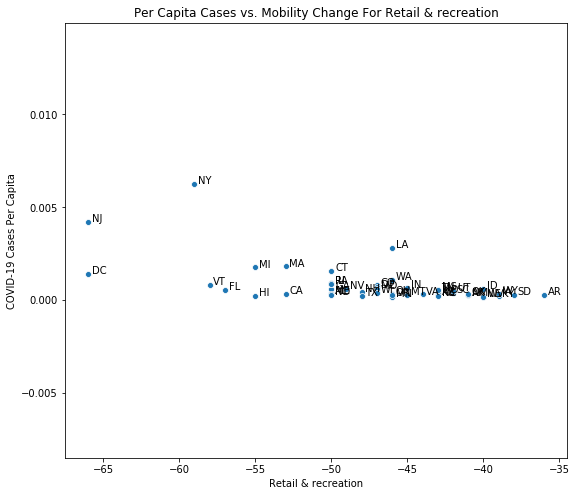

In [59]:
# set figsize and plot scatter
fig, ax = plt.subplots(figsize=(9,8))
mobility_cat = "Retail & recreation"
ax = sns.scatterplot(x=mobility_cat, y="positive_percap", data=mobility_merged)

# add annotations one by one with a loop
# https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
for row in range(0, mobility_merged.shape[0]):
     ax.text(mobility_merged[mobility_cat].iloc[row]+0.25, 
            mobility_merged["positive_percap"].iloc[row], 
            mobility_merged["state"].iloc[row], 
            horizontalalignment='left', size='medium', color='black')

# ax.set_ylim((0, 0.001))
ax.set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cat}")
ax.set_ylabel("COVID-19 Cases Per Capita");


As can see, this chart is not super helpful because of our two huge outliers, NY and NJ. Zooming in a bit, we get a better feel for the relationship between the change in visits to Retail/recreation venues and cases per capita. I've left NY and NJ in this plot purposefully so you can see how far they are from the other points. They are huge outliers, which is unsurprising. For the remainder of our mobility analysis, we'll exclude those two states.

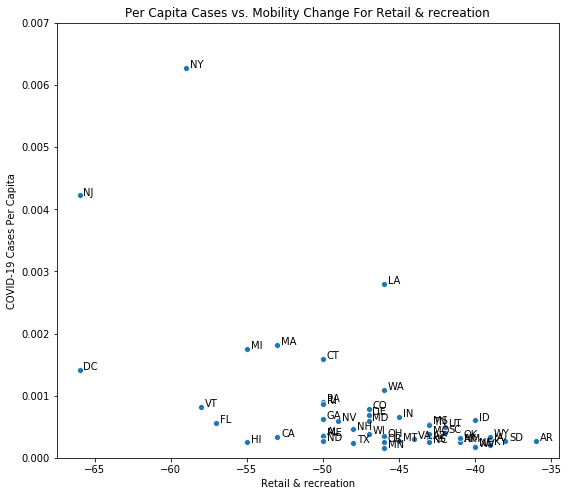

In [60]:
# set figsize and plot scatter
fig, ax = plt.subplots(figsize=(9,8))
mobility_cat = "Retail & recreation"
ax = sns.scatterplot(x=mobility_cat, y="positive_percap", data=mobility_merged)

# add annotations one by one with a loop
# https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
for row in range(0, mobility_merged.shape[0]):
     ax.text(mobility_merged[mobility_cat].iloc[row]+0.25, 
            mobility_merged["positive_percap"].iloc[row], 
            mobility_merged["state"].iloc[row], 
            horizontalalignment='left', size='medium', color='black')

ax.set_ylim((0, 0.007))
ax.set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cat}")
ax.set_ylabel("COVID-19 Cases Per Capita");


In [61]:
# remove NY and NJ
mobility_nooutliers = mobility_merged.loc[~mobility_merged["state"].isin(["NY", "NJ"])]

Now that we have removed outliers, let's examine the relationship beteween mobility and cases per capita for all mobility categories

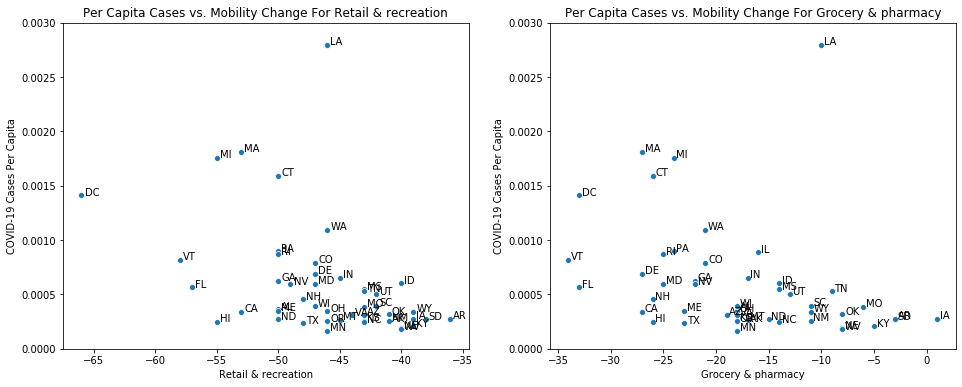

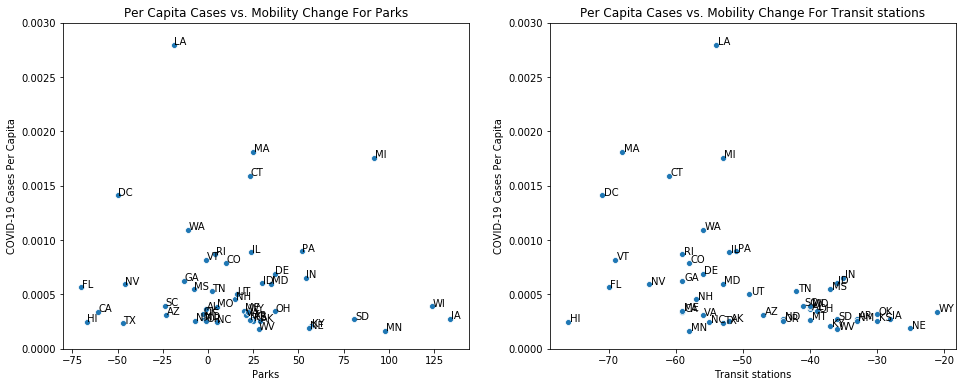

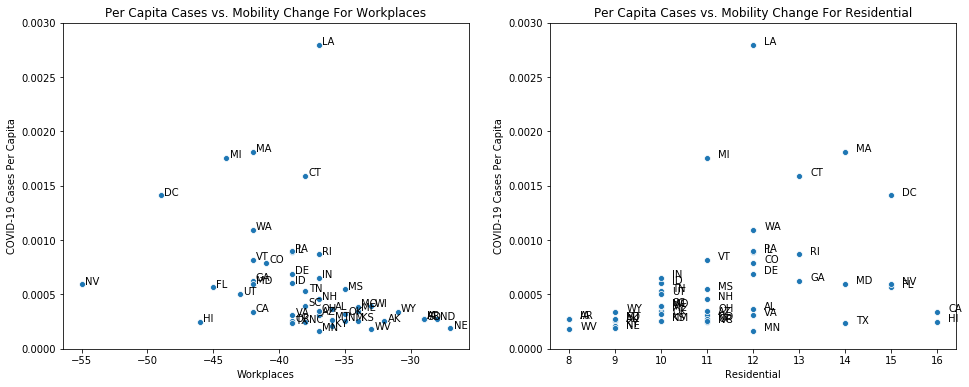

In [63]:
# set figsize and axes and plot scatter
fig, ax = plt.subplots(1, 2, figsize=(16,6))
mobility_cats = ["Retail & recreation", "Grocery & pharmacy", "Parks", "Transit stations",
                 "Workplaces", "Residential"]
ylim = (0, 0.003)

for i in range (0, 2):
    i_ax = i-0
    ax[i_ax] = sns.scatterplot(x=mobility_cats[i], y="positive_percap", data=mobility_nooutliers, ax=ax[i_ax])

    # add annotations one by one with a loop
    # https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
    for row in range(0, mobility_nooutliers.shape[0]):
        ax[i_ax].text(mobility_nooutliers[mobility_cats[i]].iloc[row]+0.25, 
                mobility_nooutliers["positive_percap"].iloc[row], 
                mobility_nooutliers["state"].iloc[row], 
                horizontalalignment='left', size='medium', color='black')

        ax[i_ax].set_ylim(ylim)
        ax[i_ax].set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cats[i]}")
        ax[i_ax].set_ylabel("COVID-19 Cases Per Capita");

fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i in range (2, 4):
    i_ax = i-2
    ax[i_ax] = sns.scatterplot(x=mobility_cats[i], y="positive_percap", data=mobility_nooutliers, ax=ax[i_ax])

    # add annotations one by one with a loop
    # https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
    for row in range(0, mobility_nooutliers.shape[0]):
        ax[i_ax].text(mobility_nooutliers[mobility_cats[i]].iloc[row]+0.25, 
                mobility_nooutliers["positive_percap"].iloc[row], 
                mobility_nooutliers["state"].iloc[row], 
                horizontalalignment='left', size='medium', color='black')

        ax[i_ax].set_ylim(ylim)
        ax[i_ax].set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cats[i]}")
        ax[i_ax].set_ylabel("COVID-19 Cases Per Capita");


fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i in range (4, 6):
    i_ax = i-4
    ax[i_ax] = sns.scatterplot(x=mobility_cats[i], y="positive_percap", data=mobility_nooutliers, ax=ax[i_ax])

    # add annotations one by one with a loop
    # https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
    for row in range(0, mobility_nooutliers.shape[0]):
        ax[i_ax].text(mobility_nooutliers[mobility_cats[i]].iloc[row]+0.25, 
                mobility_nooutliers["positive_percap"].iloc[row], 
                mobility_nooutliers["state"].iloc[row], 
                horizontalalignment='left', size='medium', color='black')

        ax[i_ax].set_ylim(ylim)
        ax[i_ax].set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cats[i]}")
        ax[i_ax].set_ylabel("COVID-19 Cases Per Capita");

In [71]:
correlations = []
correlations_nooutliers = []

for cat in mobility_cats:
    correlations.append({"mobility_category": cat,
                         "correlation": np.corrcoef(
                             mobility_merged[cat], 
                             mobility_merged["positive_percap"])[0][1]})
    correlations_nooutliers.append({"mobility_category": cat,
                         "correlation (outliers removed)": np.corrcoef(
                             mobility_nooutliers[cat], 
                             mobility_nooutliers["positive_percap"])[0][1]})

display(pd.DataFrame(correlations))
display(pd.DataFrame(correlations_nooutliers))

,mobility_category,correlation
0,Retail & recreation,-0.575766
1,Grocery & pharmacy,-0.226495
2,Parks,-0.080583
3,Transit stations,-0.431669
4,Workplaces,-0.427791
5,Residential,0.464530


,mobility_category,correlation (outliers removed)
0,Retail & recreation,-0.445372
1,Grocery & pharmacy,-0.318944
2,Parks,-0.070215
3,Transit stations,-0.413136
4,Workplaces,-0.366431
5,Residential,0.338737


This analysis is interesting. Intuitively, we would think that a decrease in mobility is associated with a *decrease* in covid cases per capita. However, we are generally seeing the opposite effect for 4/6 of our categories. Across Retail & Recreation, Grocery & Pharmacy, Transit stations, and Workplaces, a decrease in mobility is associated with an *increase* in mobility. 

Upon deeper reflection, however, this could make sense. States that are hardest hit by the pandemic in terms of covid cases would have an incentive to impose stricter "lockdown" measure, which would result in decreases in mobility. As a result, we would see lower mobility be associated with more cases. In other words mobility may be a *lagging* indicator of covid cases.

<a id='google_search_data'></a>
### Google search data
Another potential predictor of covid cases are google search trends. For example, if we see a spike in google searches for "coronavirus symptoms" or "where to get covid-19 testing" or "do I have coronavirus?" we might expect to see a subsequent spike in cases.

To conduct this analysis, we'll use [pytrends](https://github.com/GeneralMills/pytrends) a libary that allows you to query the GoogleTrends API for search data, along with [googletrands](https://py-googletrans.readthedocs.io/en/latest/), a library that allows you to translate words in python by using the GoogleTranslate API.

In [72]:
import pytrends
from pytrends.request import TrendReq
from googletrans import Translator

# connect 
pyt = TrendReq(hl='en-US', tz=300)

Now, we can start examining searhes. Let us first examine searches for "coronavirus symptoms" and "coronavirus testing"

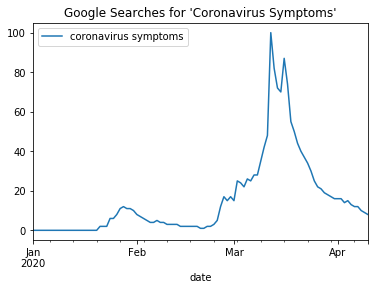

In [125]:
# build query: "coronavirus symptoms" searches starting at 2020
kw_list = ["coronavirus symptoms"]
time_frame = f'''2020-01-01 {datetime.datetime.now().strftime("%Y-%m-%d")}'''
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')

# interest over time
search_coronavirus = pyt.interest_over_time()
search_coronavirus.plot.line(y="coronavirus symptoms")
plt.title("Google Searches for 'Coronavirus Symptoms'");


Another cool feature of the pytrends library is that you can fetch suggested queries related to your own. Let's fetch keywords similar to `coronavirus`. Keep in mind that these are the top queries similar queries over the time period: `2020-01-01` to `2020-04-01` within the United States.

In [126]:
related_queries1 = pyt.related_queries()["coronavirus symptoms"]["top"].iloc[:2]["query"].values
pyt.related_queries()["coronavirus symptoms"]["top"]

,query,value
0,symptoms of coronavirus,100
1,the coronavirus symptoms,32
2,the symptoms of coronavirus,21
3,corona,16
4,corona symptoms,16
5,symptoms for coronavirus,13
6,what are coronavirus symptoms,13
7,corona virus,11
8,corona virus symptoms,11
9,what are symptoms of coronavirus,11


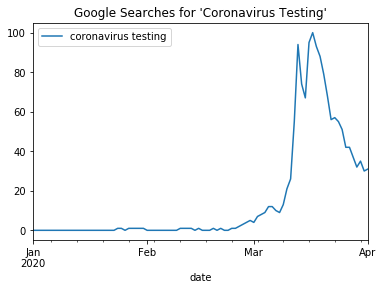

In [127]:
# build query: "coronavirus testing" searches starting at 2020
kw_list = ["coronavirus testing"]
pyt.build_payload(kw_list, cat=0, timeframe='2020-01-01 2020-04-01', geo='US', gprop='')

# interest over time
search_coronavirus = pyt.interest_over_time()
search_coronavirus.plot.line(y="coronavirus testing")
plt.title("Google Searches for 'Coronavirus Testing'");


In [128]:
related_queries2 = pyt.related_queries()["coronavirus testing"]["top"].iloc[:2]["query"].values
pyt.related_queries()["coronavirus testing"]["top"]

,query,value
0,testing for coronavirus,100
1,coronavirus testing near me,71
2,corona testing,42
3,coronavirus test,36
4,covid testing,33
5,coronavirus symptoms,27
6,corona virus testing,27
7,covid 19 testing,22
8,us testing coronavirus,22
9,testing for the coronavirus,19


Let's plot the first three related queries from each of "coronavirus testing" and "coronavirus symptoms"

In [129]:
related_queries = list(related_queries1) + list(related_queries2)
related_queries

['symptoms of coronavirus',
 'the coronavirus symptoms',
 'testing for coronavirus',
 'coronavirus testing near me']

In [130]:
# fetch top 6 related queries from 
related_queries = list(related_queries1) + list(related_queries2)

# build new query: related coronavirus queries
kw5_list = related_queries
pyt.build_payload(kw5_list, cat=0, timeframe='2020-01-01 2020-04-01', geo='US', gprop='')
top5 = pyt.interest_over_time()
top5 = top5.reset_index()
top5["date"] = pd.to_datetime(top5["date"], infer_datetime_format=True) 

In [131]:
top5.tail()

,date,symptoms of coronavirus,the coronavirus symptoms,testing for coronavirus,coronavirus testing near me,isPartial
87,2020-03-28,20,7,2,2,False
88,2020-03-29,18,7,2,2,False
89,2020-03-30,18,7,2,2,False
90,2020-03-31,17,7,2,2,False
91,2020-04-01,19,7,2,2,False


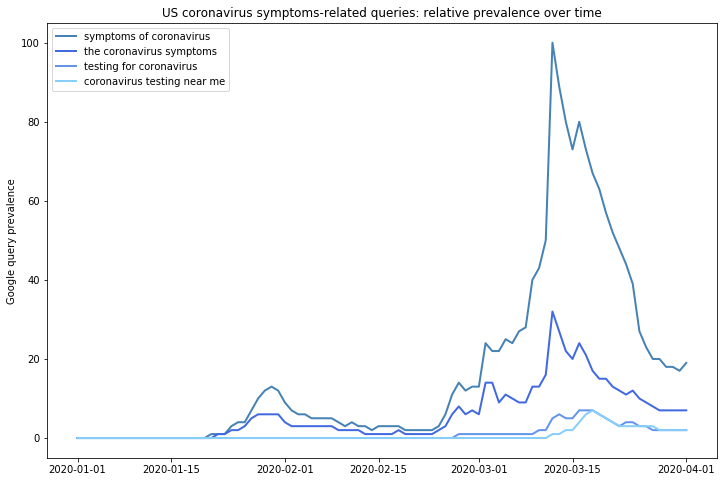

In [133]:
# now plot top related queries
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot("date", kw5_list[0], data=top5, color='steelblue', linewidth=2)
plt.plot("date", kw5_list[1], data=top5, color='royalblue', linewidth=2)
plt.plot("date", kw5_list[2], data=top5, color='cornflowerblue', linewidth=2) 
plt.plot("date", kw5_list[3], data=top5, color='lightskyblue', linewidth=2)
# plt.plot("date", kw5_list[4], data=top5, color='lightsteelblue', linewidth=2)
plt.legend(loc="upper left")
plt.ylabel("Google query prevalence")
plt.title("US coronavirus symptoms-related queries: relative prevalence over time");


Interesting - now let's overlay a plot of US coronavirus cases

In [135]:
# fetch US data and clean date
covid_us = covid_global.loc[covid_global["country"] == "US"]
covid_us["date"] =  pd.to_datetime(covid_us["date"], infer_datetime_format=True)  

# merge search
search_cases_us = top5.merge(covid_us, left_on="date", right_on="date", how="inner")#[[
#    "date", "coronavirus update", "coronavirus symptoms", "coronavirus cases", 
 #   "coronavirus us", "coronavirus map", "confirmed"]]
search_cases_us["new_confirmed"] = search_cases_us["confirmed"].diff()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


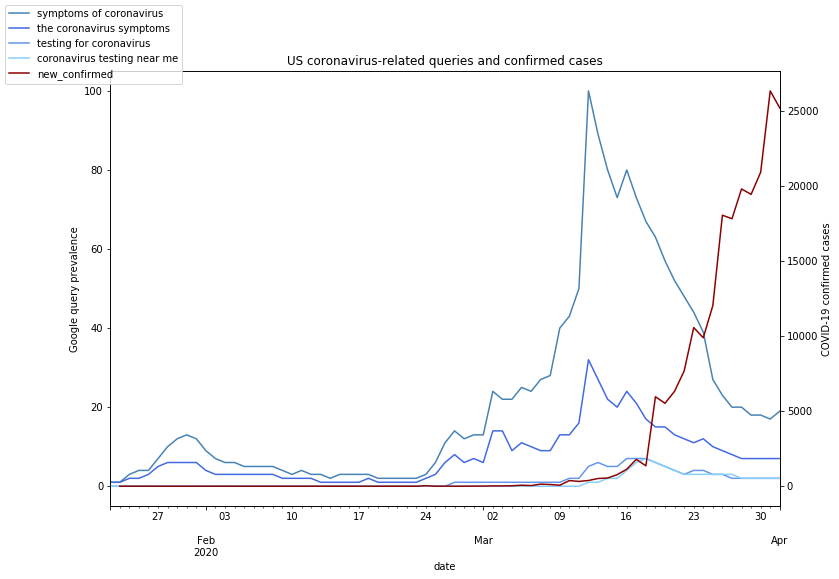

In [136]:
# now plot top 5 related queries with confirmed cases
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
search_cases_us.plot(x="date", y=kw5_list[0], color="steelblue",  ax=ax1, legend=False)
search_cases_us.plot(x="date", y=kw5_list[1], color="royalblue", ax=ax1, legend=False)
search_cases_us.plot(x="date", y=kw5_list[2], color="cornflowerblue", ax=ax1, legend=False)
search_cases_us.plot(x="date", y=kw5_list[3], color="lightskyblue", ax=ax1, legend=False)
# search_cases_us.plot(x="date", y=kw5_list[4], color="lightsteelblue", ax=ax1, legend=False)
ax2 = ax1.twinx()
# search_cases_us.plot(x="date", y="confirmed", ax=ax2, legend=False, color="r")
search_cases_us.plot(x="date", y="new_confirmed", ax=ax2, legend=False, color="darkred")

ax1.figure.legend(loc="upper left")
ax1.set_title("US coronavirus-related queries and confirmed cases")
ax1.set_ylabel("Google query prevalence")
ax2.set_ylabel("COVID-19 confirmed cases")
plt.show();

**Analysis**

Interestingly, in the US at least, it appears that there was a spike in coronavirus symptoms-related searches about two weeks before the massive spike in confirmed cases. At first glance, it appears this could be a good predictor of actual coronavirus cases. If that is the case, then the drop in "symptoms" searches might be predictive of a leveling off of confirmed cases.

Let's look at a different country that is further along in its curve: South Korea


First, let's build a function that allows us to translate a list of strings.

In [172]:
translator = Translator()

def translate_bulk(words, source="en", destination="en"):
    out = []
    
    translations = translator.translate(words, src=source, dest=destination)
    for t in translations:
        out.append(t.text)
        
    return out

In [156]:
# now, let's get a translation for coronavirus
# "코로나 바이러스" is the literal translation, but is more commonly referred to as "코로나" ("corona") in Korea
translate_bulk(["coronavirus"], destination="ko")

['코로나 바이러스']

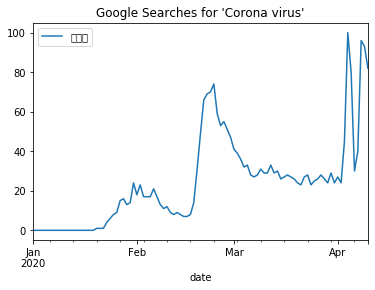

In [203]:
# build query: coronavirus searches starting at 2020, for south korea
kw_list = ["코로나"]
kw_trans = translate_bulk(['코로나 바이러스'], source="ko", destination='en')
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='KR', gprop='')

# interest over time
search_coronavirus = pyt.interest_over_time()
search_coronavirus.plot.line(y=kw_list[0])
plt.title(f"Google Searches for '{kw_trans[0]}'");


In [205]:
# fetch and translate related queries
related_queries = pyt.related_queries()[kw_list[0]]["top"]
related_queries["query_en"] = translate_bulk(list(related_queries["query"]), source="ko", destination='en')
related_queries

,query,value,query_en
0,코로나 19,100,covid-19
1,코로나 바이러스,76,Corona virus
2,코로나 확진,67,Corona confirmed
3,코로나 확진 자,61,Corona party confirmed
4,코로나 19 극복 을 위해 노력 하시는 모든 분들께 감사 드립니다,42,Thank you to all who strive to overcome Corona 19
5,코로나 현황,27,Corona Status
6,코로나 바이러스 19,26,Corona virus 19th
7,코로나 바이러스 19 관련 정보,24,Corona virus-related information 19
8,코로나 증상,19,Corona symptoms
9,신종 코로나,16,Swine Corona


In [239]:
# fetch top 5 related queries from SK
kw5_list = list(related_queries.loc[:4]["query"])

# build new query: related coronavirus queries
pyt.build_payload(kw5_list, cat=0, timeframe=time_frame, geo='KR', gprop='')
top5 = pyt.interest_over_time()
top5 = top5.reset_index()
top5["date"] = pd.to_datetime(top5["date"], infer_datetime_format=True) 

# transate search keywords to english
translation_lookup = {}
for col in top5.columns[1:6]:
    translation_lookup[col] = translate_bulk([col], source="ko", destination="en")[0]

top5 = top5.rename(columns=translation_lookup)

In [242]:
# fetch south korea data and clean date
covid_sk = covid_global.loc[covid_global["country"] == "Korea, South"]
covid_sk["date"] =  pd.to_datetime(covid_sk["date"], infer_datetime_format=True)  

# merge search
search_cases_sk = top5.merge(covid_sk, left_on="date", right_on="date", how="inner")
search_cases_sk["new_confirmed"] = search_cases_sk["confirmed"].diff()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


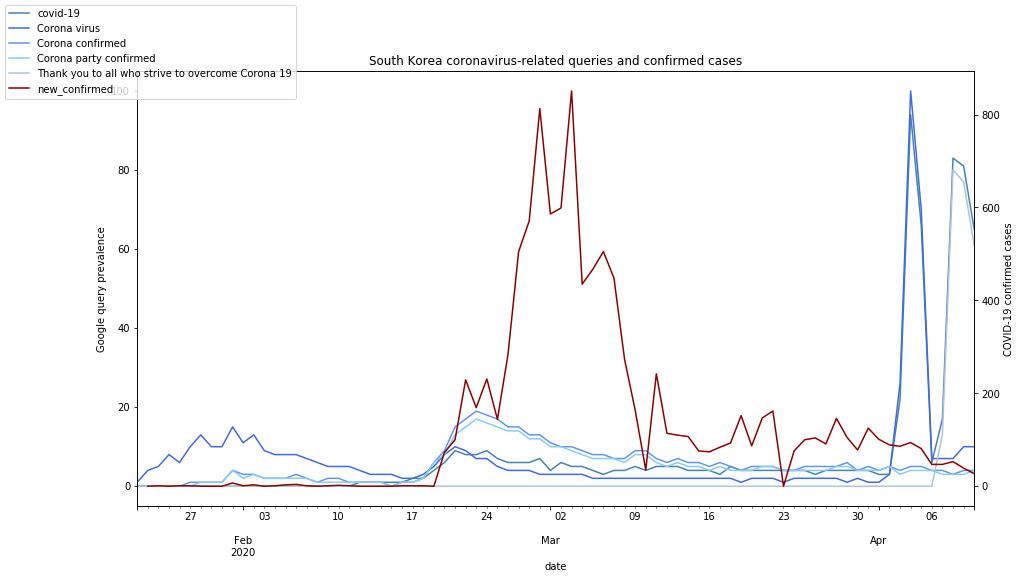

In [251]:
# now plot top 5 related queries with confirmed cases
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(111)
search_cases_sk.plot(x="date", y=related_queries.iloc[:5]["query_en"][0], color="steelblue",  ax=ax1, legend=False)
search_cases_sk.plot(x="date", y=related_queries.iloc[:5]["query_en"][1], color="royalblue", ax=ax1, legend=False)
search_cases_sk.plot(x="date", y=related_queries.iloc[:5]["query_en"][2], color="cornflowerblue", ax=ax1, legend=False)
search_cases_sk.plot(x="date", y=related_queries.iloc[:5]["query_en"][3], color="lightskyblue", ax=ax1, legend=False)
search_cases_sk.plot(x="date", y=related_queries.iloc[:5]["query_en"][4], color="lightsteelblue", ax=ax1, legend=False)
ax2 = ax1.twinx()
# search_cases_us.plot(x="date", y="confirmed", ax=ax2, legend=False, color="r")
search_cases_sk.plot(x="date", y="new_confirmed", ax=ax2, legend=False, color="darkred")

ax1.figure.legend(loc="upper left")
ax1.set_title("South Korea coronavirus-related queries and confirmed cases")
ax1.set_ylabel("Google query prevalence")
ax2.set_ylabel("COVID-19 confirmed cases")
plt.show();

<a id='future_ideas'></a>
## Takeaways and future ideas

This was a good start, and gave us a decent idea of the available real world data available to us "in the wild". It appears that the GoogleTrends search data is the most promising in terms of predicting covid cases. In addition, although the mobility data seemed to be at odds with our initial intuition, we think that if coupled with other data points (e.g. state policies like lockdowns, and when they went into effect), the mobility data could still be highly useful.

#### Additional data and data engineering
Addition fields that we may explore in the future include
- Whether state went on lockdown
- How many days it's been since lockdown
- The severity of the lockdown measure (e.g. mandatory curfew + closure of non-essential businesses vs. recommendations)
- What percent of hospital capacity the state is at [IHME](http://www.healthdata.org/) has good data on this
